# Kaggle competition link: https://www.kaggle.com/c/titanic/overview

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.


# My main objectives on this project are:
1. Explorating and visualising the data, trying to get some insights about our dataset
2. Then try to build a model to predict the passenger's survival

# In this notebook I am going to try explore the data and answer questions like:

1. What is the survival rate for specific groups?
2. Is there any relation between given info of passengers and their survival?
3. Was women and children first policy in order?
4. Having higher social status in helped people getting in life boats?
5. The mustering order from captain was highly dependent on the class of the passengers, can we spot this effect between pclass and the survival rates?
6. What are the effects of being alone or with family?

In [1]:
# Importing neccesary packages.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy import stats

pd.options.display.max_columns = 50
plt.style.use('ggplot')

In [2]:
# reading dataset
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [3]:
# Checking data sample
display(train.sample(5))
display(test.sample(5))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
240,241,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
728,729,0,2,"Bryhl, Mr. Kurt Arnold Gottfrid",male,25.0,1,0,236853,26.0000,NaN,S
631,632,0,3,"Lundahl, Mr. Johan Svensson",male,51.0,0,0,347743,7.0542,NaN,S
58,59,1,2,"West, Miss. Constance Mirium",female,5.0,1,2,C.A. 34651,27.7500,NaN,S
486,487,1,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
37,929,3,"Cacic, Miss. Manda",female,21.0,0,0,315087,8.6625,NaN,S
154,1046,3,"Asplund, Master. Filip Oscar",male,13.0,4,2,347077,31.3875,NaN,S
189,1081,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S
169,1061,3,"Hellstrom, Miss. Hilda Maria",female,22.0,0,0,7548,8.9625,NaN,S
129,1021,3,"Petersen, Mr. Marius",male,24.0,0,0,342441,8.0500,NaN,S


# Exploring the data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#Drop unnecessary column to speed up the process
train = train.drop(['Cabin', 'Ticket'], axis=1)
test  = test.drop(['Cabin', 'Ticket'], axis=1)
combine = pd.merge(train, test, how='outer')

# Categorical Features

1. Survived: Indicates that if particular passenger survived(1) or not(0)
2. Pclass  : Shows classes for the passenger, 1 for first, 2 for second and 3 for third.
3. Sex     : Indicates gender of the passenger. Might be crucial indicator for our model since historical records show women were first to save in ship accidents.
4. SibSp   : The number of siblings and spouses on the ship, might be useful for extracting family ties.
5. Parch   : The number of parents and children on the ship, migt have similar use with SibSp.
6. Embarked: Flag for the where the passenger embarked from, C for Cherbourg, Q for Queenstown, S for Southampto

In [6]:
# Selecting categorical data
cats = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

In [7]:
def plotFrequency(cats):
    fig, ax = plt.subplots(2,3,figsize=(20,15))
    for i, cat in enumerate(cats,1):
        plt.subplot(2,3,i)
        sns.countplot(train[cat])
       

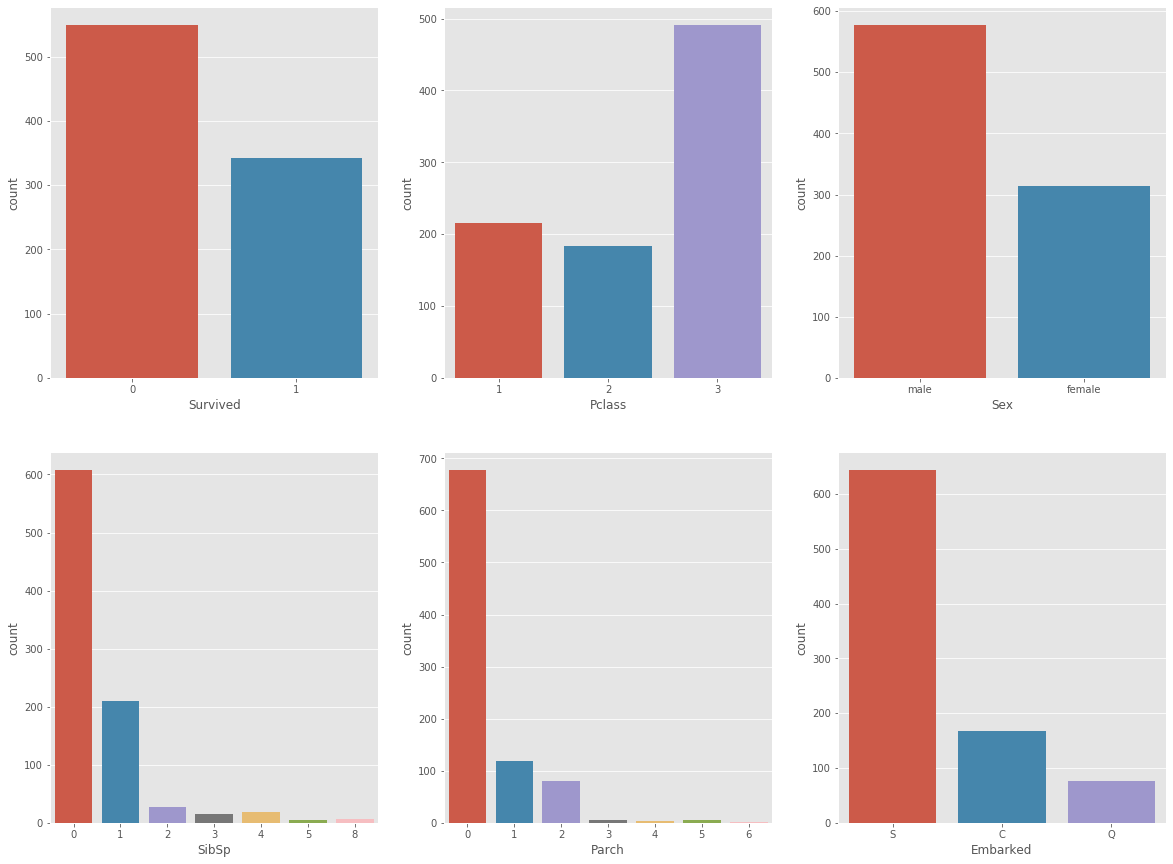

In [8]:
plotFrequency(cats)

In [9]:
def plotSurvival(cats):
    fig, ax = plt.subplots(2,3,figsize=(20,15))
    for i, cat in enumerate(cats,1):
        if cat == 'Survived':
            plt.subplot(2,3,i)
            sns.countplot(train[cat]) 
        else:
            plt.subplot(2,3,i)
            sns.countplot(x=cat, data=train, hue='Survived')          
            plt.legend(['No', 'Yes'], title = 'Survived', loc='upper center')

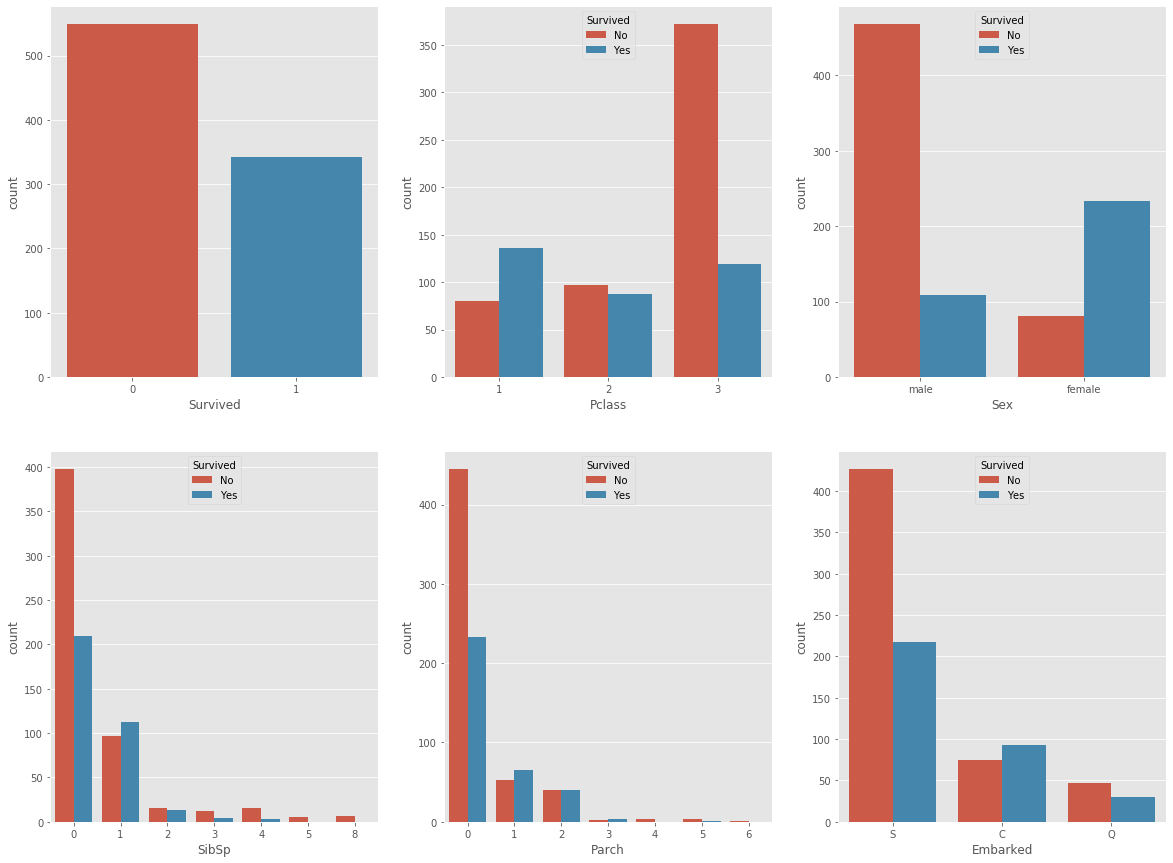

In [10]:
plotSurvival(cats)

Observations:

1. Sadly most of the train set passengers are not survived, around 62%.
2. While having highest portion of the passengers on the ship, 3rd class also having highest casuality ratio. Meanwhile first class have more survival rate. So this kind of confirms our hypothesis that mustering orders from captain (1>2>3) might have effect on survival.
3. Again most of the passengers on the ship are males(around two third of the passengers) they also have much higher ratio of casualities too. This confirms women part of the "Women and children first policy" had an effect in our Titanic case.
4. Most of our passengers are travelling alone, they also have high casuality rate. So being married or with family has some positive effect on survival?
5. Most of the passenger are embarked from Southampton. Survival rates differ between ports but I'm not sure if it's important observation or just random.

These are rough observations from inspecting some categorical data, let's continue with numerical ones...

In [11]:
# Let's encode them for later modeling

# Gender
combine.loc[combine['Sex']=='male', 'Sex'] = 0
combine.loc[combine['Sex']=='female', 'Sex'] = 1

# Embarked
embarked_mapping = {'S':0, 'C':1, 'Q':2}
combine['Embarked'] = combine['Embarked'].map(embarked_mapping)
combine['Embarked'].fillna(0, inplace=True)

# For the number of Sibling/Spouse/Family member, we will only consider the passeger alone or not
combine.loc[(combine['SibSp']==0) & (combine['Parch']==0), 'Alone'] = 1
combine.loc[combine['SibSp']>0, 'Alone'] = 0
combine.loc[combine['Parch']>0, 'Alone'] = 0

combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Alone
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1.0,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0.0,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,0.0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0.0,1.0


In [12]:
# Now we can drop these columns
combine.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Numerical Features

In [13]:
combine[['Age', 'Fare']].isna().sum()

Age     263
Fare      1
dtype: int64

In [14]:
combine.sample(10)

# Here the current dataset. 
# There is significant data of Age is missing we will try to guess their age based on their gender, Pclass
# Guessed Age values using mean values for Age across sets of Pclass and Gender feature combinations

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Alone
990,991,NaN,3,"Nancarrow, Mr. William Henry",0,33.0,8.0500,0.0,1.0
1206,1207,NaN,3,"Hagardon, Miss. Kate",1,17.0,7.7333,2.0,1.0
1290,1291,NaN,3,"Conlon, Mr. Thomas Henry",0,31.0,7.7333,2.0,1.0
348,349,1.0,3,"Coutts, Master. William Loch ""William""",0,3.0,15.9000,0.0,0.0
832,833,0.0,3,"Saad, Mr. Amin",0,NaN,7.2292,1.0,1.0
655,656,0.0,2,"Hickman, Mr. Leonard Mark",0,24.0,73.5000,0.0,0.0
173,174,0.0,3,"Sivola, Mr. Antti Wilhelm",0,21.0,7.9250,0.0,1.0
396,397,0.0,3,"Olsson, Miss. Elina",1,31.0,7.8542,0.0,1.0
1088,1089,NaN,3,"Nilsson, Miss. Berta Olivia",1,18.0,7.7750,0.0,1.0
641,642,1.0,1,"Sagesser, Mlle. Emma",1,24.0,69.3000,1.0,1.0


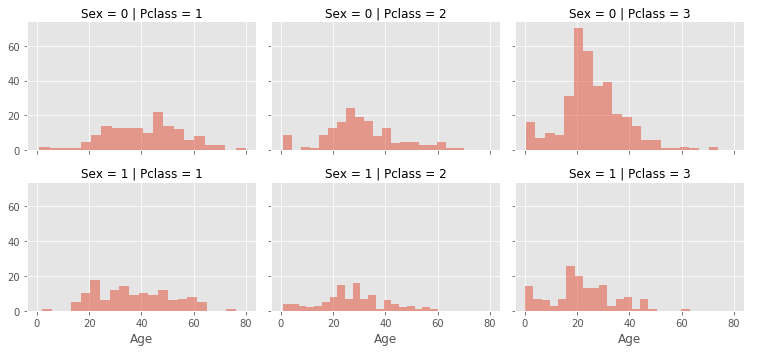

In [15]:
# Let's check age distribution by Pclass and Sex
grid = sns.FacetGrid(combine, col='Pclass', row='Sex', height = 2.5, aspect = 1.4)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [16]:
# Guess age based on the combination of Pclass & Sex:
for i in range(2):
    for j in range(1,4):
        x = combine[(combine['Sex'] == i) & (combine['Pclass'] == j)][['Sex','Pclass','Age']].groupby(['Sex', 'Pclass'])
        for idx, row in combine[(combine['Sex'] == i) & (combine['Pclass'] == j)].iterrows():
            if math.isnan(row.Age):
                combine.loc[idx, 'Age'] = round(np.random.uniform(x.mean() - 2*x.std(), x.mean() + 2*x.std())[0][0])

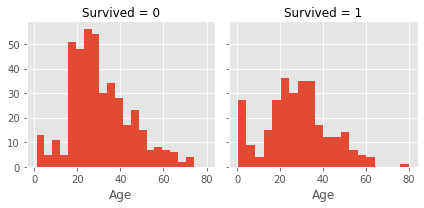

In [17]:
# Plotting survivors by Age
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

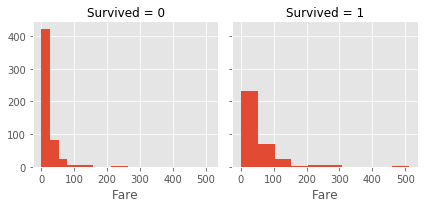

In [18]:
# Plotting survivor by Fare
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Fare')

In [19]:
def plot_3chart(df, feature):
    import matplotlib.gridspec as gridspec
    from matplotlib.ticker import MaxNLocator
    # Creating a customized chart. and giving in figsize
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    grid = gridspec.GridSpec(nrows=3, ncols=3, figure=fig)
    
    # Plotting histogram grid
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature].dropna()
                , hist=True
                , kde=True
                , fit=norm
                , ax=ax1)
    ax1.legend(labels=['Normal', 'Actual'])
    
    # Plotting the qq_plot
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('qq_plot')
    stats.probplot(df.loc[:, feature].dropna()
                  , plot=ax2)
    
    #Plotting the Boxplot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Boxplot')
    sns.boxplot(df.loc[:, feature].dropna()
               , orient='v'
               , ax=ax3)
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))  

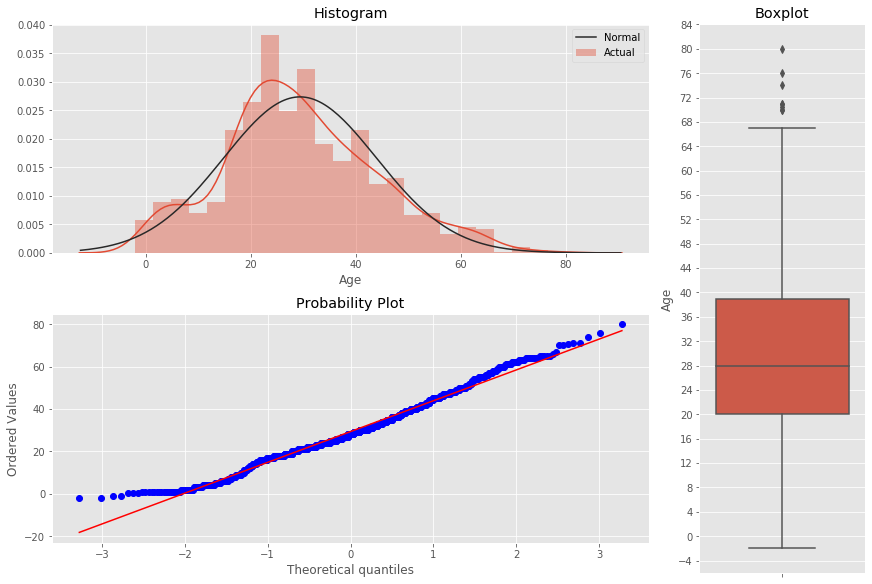

In [20]:
plot_3chart(combine, 'Age')

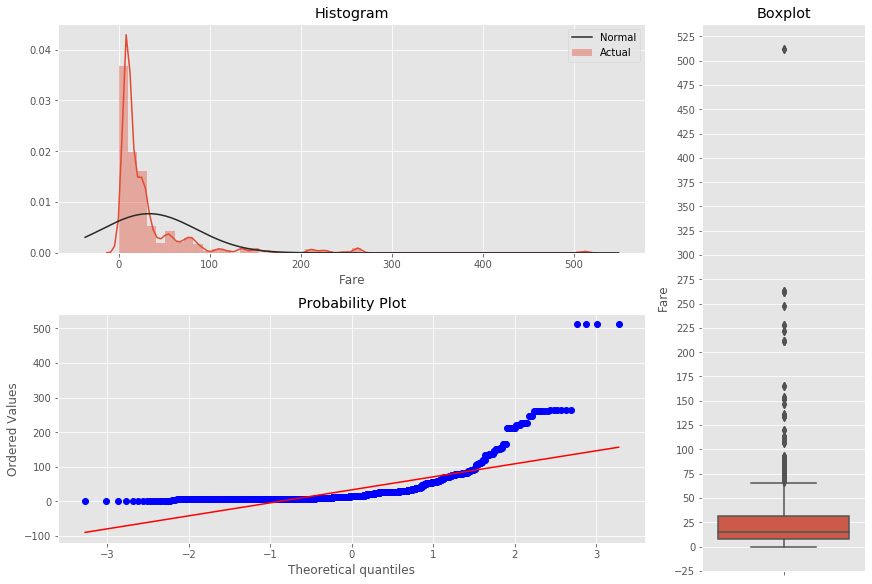

In [21]:
plot_3chart(combine, 'Fare')

Observations:
1. Seems our Age values distrubuted well, little right skewed with high number of young adults. With the median age of 28 there are little bit of ouliers but things look ordinal.

2. Fare distrubution doesn't look good, not fitting normal distrubution at all. While most of the passenger fares are below 30, there are some crazy outliers lying there like 500+ spent on tickets.

Let's group them 

In [22]:
# Group Age based on the distribution
combine.loc[combine['Age'] <= 16, 'Age'] = 0
combine.loc[(combine['Age'] > 16) & (combine['Age'] <= 32), 'Age'] = 1
combine.loc[(combine['Age'] > 32) & (combine['Age'] <= 48), 'Age'] = 2
combine.loc[(combine['Age'] > 48) & (combine['Age'] <= 64), 'Age'] = 3
combine.loc[ combine['Age'] > 64, 'Age'] = 4
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Alone
0,1,0.0,3,"Braund, Mr. Owen Harris",0,1.0,7.2500,0.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2.0,71.2833,1.0,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,1.0,7.9250,0.0,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,53.1000,0.0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",0,2.0,8.0500,0.0,1.0


In [23]:
train = combine[:891]
print(train[['Age', 'Survived']].groupby('Age').mean())

     Survived
Age          
0.0  0.466216
1.0  0.355721
2.0  0.385542
3.0  0.412500
4.0  0.083333


- It seems young people (group 1) tend to help the children and older people get out of disater but can not help themself
- Elder people have low change of survival

In [24]:
# Group and encode Fare:
combine['FareBand'] = pd.qcut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 31.275]",0.441048
3,"(31.275, 512.329]",0.600000


In [25]:
combine.drop('FareBand', axis=1, inplace=True)

In [26]:
combine.loc[combine['Fare'] <= 7.896, 'Fare'] = 0
combine.loc[(combine['Fare'] > 7.896) & (combine['Fare'] <= 14.454), 'Fare'] = 1
combine.loc[(combine['Fare'] > 14.454) & (combine['Fare'] <= 31.275), 'Fare'] = 2
combine.loc[combine['Fare'] > 31.275, 'Fare'] = 3

In [27]:
combine['Fare'].isna().sum()
combine['Fare'].fillna(1, inplace=True)

In [28]:
# We want to extract name title from passenger's name to test correlation between titles and survival
combine['Title'] = combine.Name.str.extract(' ([A-Za-z]+)\.', expand=False) 

In [29]:
pd.crosstab(combine['Title'], combine['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,4,0
Countess,0,1
Don,1,0
Dona,0,1
Dr,7,1
Jonkheer,1,0
Lady,0,1
Major,2,0


In [30]:
# We can replace many titles with a more common name or classify them as Rare.
combine['Title'] = combine['Title'].replace(['Countess', 'Dona', 'Dr', 'Lady'
                                             , 'Capt', 'Col', 'Jonkheer', 'Major', 'Rev', 'Sir', 'Don'], 'Rare')

In [31]:
combine['Title'] = combine['Title'].replace('Mlle', 'Miss')
combine['Title'] = combine['Title'].replace('Ms', 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

In [32]:
# let's see their survival rate first
train = combine[:891]
print(train[['Title', 'Survived']].groupby('Title').mean())

# The result consolidates our earlier asumption: Woman first!

        Survived
Title           
Master  0.575000
Miss    0.702703
Mr      0.156673
Mrs     0.793651
Rare    0.347826


- It's remarkable correlation between title and survival rate. 
- We will add title to the training model. 
- Let's encode it now!

In [33]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

combine['Title'] = combine['Title'].map(title_mapping)
combine['Title'] = combine['Title'].fillna(0)


In [34]:
# Final dataset for modeling and predicting
combine.drop(['PassengerId', 'Name'], axis=1, inplace=True)
test = combine[891:]
train= combine[:891]
print(train.sample(10))

     Survived  Pclass  Sex  Age  Fare  Embarked  Alone  Title
821       1.0       3    0  1.0   1.0       0.0    1.0      1
278       0.0       3    0  0.0   2.0       2.0    0.0      4
485       0.0       3    1  1.0   2.0       0.0    0.0      2
811       0.0       3    0  2.0   2.0       0.0    1.0      1
108       0.0       3    0  2.0   0.0       0.0    1.0      1
412       1.0       1    1  2.0   3.0       2.0    0.0      2
611       0.0       3    0  1.0   0.0       0.0    1.0      1
254       0.0       3    1  2.0   2.0       0.0    0.0      3
268       1.0       1    1  3.0   3.0       0.0    0.0      3
582       0.0       2    0  3.0   2.0       0.0    1.0      1


# Model, predict and solve the problem

 1. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...)
 2. We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. 
 3. According to these reasons, here my choice of model:
- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Linear Support Vector Classification
- RVM or Relevance Vector Machine

In [35]:
# import machine learning package
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

In [36]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("Survived", axis=1)
Y_test = pd.read_csv('gender_submission.csv')['Survived'].values
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [37]:
# Logistic Regression

logreg = LogisticRegression(solver='saga')
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
logreg_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(logreg_acc))

Predict accuracy: 94.74%


In [38]:
# KNN or k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
knn_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(knn_acc))

Predict accuracy: 85.17%


In [39]:
# Support Vector Machines
svc = SVC(gamma='auto')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
svc_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(svc_acc))

Predict accuracy: 90.67%


In [40]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
gaussian_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(gaussian_acc))

Predict accuracy: 89.23%


In [41]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
decision_tree_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(decision_tree_acc))

Predict accuracy: 85.89%


In [42]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(random_forest_acc))

Predict accuracy: 85.41%


In [43]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
perceptron_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(perceptron_acc))

Predict accuracy: 86.36%


In [44]:
# Linear Support Vector Classification
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
linear_svc_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(linear_svc_acc))

Predict accuracy: 98.33%


In [45]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
sgd_acc = round(accuracy_score(Y_test, Y_pred) * 100, 2)

print('Predict accuracy: {}%'.format(sgd_acc))

Predict accuracy: 87.56%


In [47]:
# Final Model Ranking
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [svc_acc, knn_acc, logreg_acc, 
              random_forest_acc, gaussian_acc, perceptron_acc, 
              sgd_acc, linear_svc_acc, decision_tree_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Linear SVC,98.33
2,Logistic Regression,94.74
0,Support Vector Machines,90.67
4,Naive Bayes,89.23
6,Stochastic Gradient Decent,87.56
5,Perceptron,86.36
8,Decision Tree,85.89
3,Random Forest,85.41
1,KNN,85.17
